In [1]:
pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.under_sampling import NearMiss
import joblib

In [3]:
# Load Full dataset
datasetF = pd.read_csv('Dataset/dataset_full.csv')

In [4]:
# Drop duplicated values
duplicated_rows = datasetF.duplicated()
if duplicated_rows.any():
    print(f"\nNumber of duplicated rows: {duplicated_rows.sum()}")
datasetF = datasetF.drop_duplicates()


Number of duplicated rows: 1438


In [5]:
# Load Small dataset
datasetS = pd.read_csv('Dataset/small_dataset.csv')
dataset = pd.concat([datasetF, datasetS], axis=0)
dataset.shape

(144614, 112)

In [6]:
# Drop columns with only one unique value
dataset = dataset.loc[:, (dataset.nunique() > 1).tolist()]
print(dataset.shape)

(144614, 99)


In [7]:
dataset['qty_questionmark_directory'].value_counts()

qty_questionmark_directory
 0    81772
-1    62842
Name: count, dtype: int64

In [8]:
# Drop columns with -1 as missing value
columns_to_drop = ['qty_questionmark_directory', 'qty_hashtag_directory', 'qty_slash_file', 'qty_questionmark_file', 'qty_hashtag_file', 'qty_dollar_file']
existing_columns_to_drop = [col for col in columns_to_drop if col in dataset.columns]
dataset = dataset.drop(existing_columns_to_drop, axis=1)

In [9]:
dataset['qty_hashtag_params'].value_counts()

qty_hashtag_params
-1    129888
 0     14726
Name: count, dtype: int64

In [10]:
# Replace -1 values
columns_to_replace_0 = ['qty_dot_params', 'qty_hyphen_params', 'qty_underline_params', 'qty_slash_params', 'qty_questionmark_params', 'qty_at_params', 'qty_exclamation_params',
                        'qty_space_params', 'qty_tilde_params', 'qty_comma_params', 'qty_plus_params', 'qty_hashtag_params', 'qty_asterisk_params', 'qty_dollar_params', 
                        'qty_percent_params', 'tld_present_params']
existing_columns_to_replace_0 = [col for col in columns_to_replace_0 if col in dataset.columns]
dataset[existing_columns_to_replace_0] = dataset[existing_columns_to_replace_0].replace(-1, 0)

columns_to_replace_2 = ['qty_equal_params']
existing_columns_to_replace_2 = [col for col in columns_to_replace_2 if col in dataset.columns]
dataset[existing_columns_to_replace_2] = dataset[existing_columns_to_replace_2].replace(-1, 2)

columns_to_replace_1 = ['qty_and_params', 'qty_params']
existing_columns_to_replace_1 = [col for col in columns_to_replace_1 if col in dataset.columns]
dataset[existing_columns_to_replace_1] = dataset[existing_columns_to_replace_1].replace(-1, 1)

columns_to_replace_40 = ['params_length']
existing_columns_to_replace_40 = [col for col in columns_to_replace_40 if col in dataset.columns]
dataset[existing_columns_to_replace_40] = dataset[existing_columns_to_replace_40].replace(-1, 40)


In [11]:
# Drop only one unique value
dataset = dataset.loc[:, (dataset.nunique() > 1).tolist()]

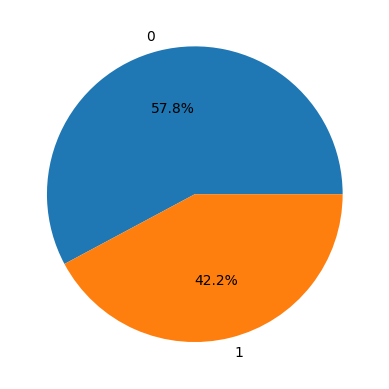

In [12]:
# Visualize
idx = dataset['phishing'].value_counts().index
vals = dataset['phishing'].value_counts().values
plt.pie(x=vals, labels=idx, autopct='%2.1f%%')
plt.show()

In [13]:
# features and target
X = dataset.drop('phishing', axis=1)
y = dataset['phishing']

mean_importance: 0.011
Top 20 features:
- directory_length
- time_domain_activation
- asn_ip
- time_response
- length_url
- ttl_hostname
- qty_dot_domain
- time_domain_expiration
- qty_nameservers
- domain_length
- qty_slash_url
- qty_mx_servers
- qty_ip_resolved
- qty_vowels_domain
- qty_hyphen_directory
- qty_redirects
- file_length
- qty_dot_url
- qty_slash_directory
- tls_ssl_certificate
Updated X shape: (144614, 20)


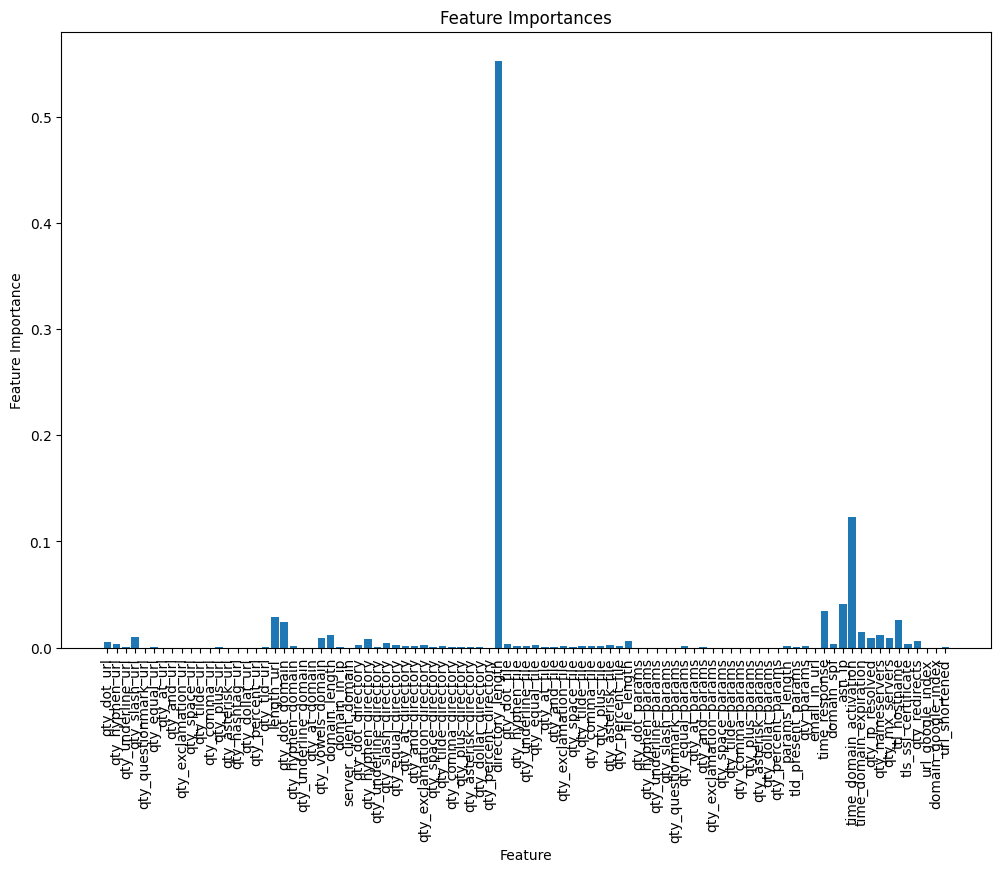

In [14]:
# feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importances = rf.feature_importances_
feature_names = X.columns

mean_importance = np.mean(feature_importances)
print(f"mean_importance: {mean_importance:.3f}")

top_20_features = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)[:20]
top_20_feature_names = [name for name, _ in top_20_features]

print(f"Top 20 features:")
for feature in top_20_feature_names:
    print(f"- {feature}")

top_20_features_df = pd.DataFrame({'feature': top_20_feature_names})

X = X.loc[:, top_20_features_df['feature']]
print(f"Updated X shape: {X.shape}")


plt.figure(figsize=(12, 8))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xticks(range(len(feature_importances)), feature_names, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Feature Importances")
plt.show()

Class distribution after resampling:
Class 0: 60994
Class 1: 60994


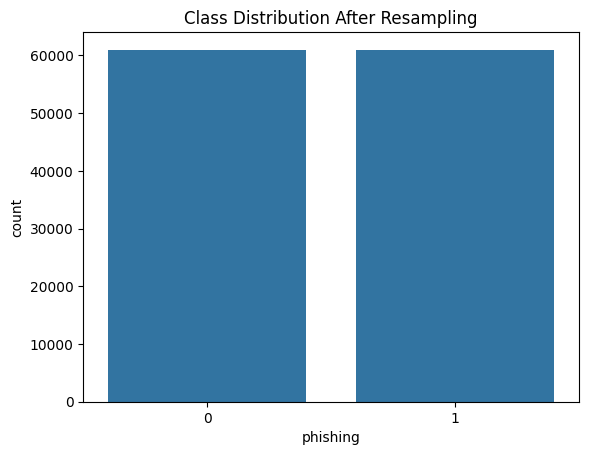

(121988, 20)


In [15]:
# handle the imbalance
nm = NearMiss()
X_resampled, y_resampled = nm.fit_resample(X, y)
X_resampled = pd.DataFrame(X_resampled, columns=top_20_feature_names)


X_resampled = pd.DataFrame(X_resampled, columns=top_20_feature_names)


unique, counts = np.unique(y_resampled, return_counts=True)
print("Class distribution after resampling:")
for label, count in zip(unique, counts):
    print(f"Class {label}: {count}")


sns.countplot(x=y_resampled)
plt.title("Class Distribution After Resampling")
plt.show()

print(X_resampled.shape)

In [16]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [17]:
# Training the model 
Rf = RandomForestClassifier(
    n_estimators=350, 
    max_depth=35,
    max_features=int(X.shape[1] ** 0.5),
    criterion='gini',
    bootstrap=False,
    n_jobs=-1,
    random_state=42
)
Rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=35, max_features=4,
                       n_estimators=350, n_jobs=-1, random_state=42)

In [18]:
# Predict on training and test sets
y_train_pred = Rf.predict(X_train)
y_test_pred = Rf.predict(X_test)

In [19]:
# Calculate accuracy, precision, recall, and F1 score
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)


print(f"Training Accuracy: {100*train_accuracy:.2f}%")
print(f"Test Accuracy: {100*test_accuracy:.2f}%")
print(f"Test Precision: {100*test_precision:.2f}%")
print(f"Test Recall: {100*test_recall:.2f}%")
print(f"Test F1 Score: {100*test_f1:.2f}%")


overall_accuracy = (accuracy_score(y_train, y_train_pred) + accuracy_score(y_test, y_test_pred)) / 2
print(f"Overall Accuracy: {100*overall_accuracy:.2f}%")

from sklearn.metrics import classification_report

class_report = classification_report(y_test, y_test_pred)
print("\nClassification Report:")
print("\n"+class_report)


Training Accuracy: 99.99%
Test Accuracy: 98.81%
Test Precision: 98.59%
Test Recall: 99.01%
Test F1 Score: 98.80%
Overall Accuracy: 99.40%

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18428
           1       0.99      0.99      0.99     18169

    accuracy                           0.99     36597
   macro avg       0.99      0.99      0.99     36597
weighted avg       0.99      0.99      0.99     36597



In [20]:
# Save model
joblib.dump(Rf, '../Model/random_forest_model.pkl')
joblib.dump(top_20_feature_names, '../Model/feature_names.pkl')

print("Model and feature names saved to 'random_forest_model.pkl' and 'feature_names.pkl'")

Model and feature names saved to 'random_forest_model.pkl' and 'feature_names.pkl'


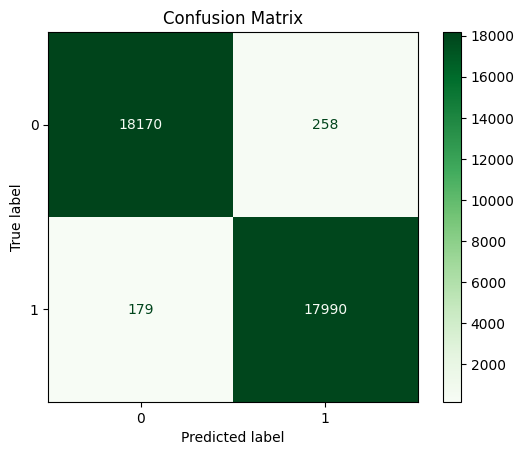

In [22]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=Rf.classes_)
disp.plot(cmap=plt.cm.Greens) 
plt.title("Confusion Matrix")
plt.show()

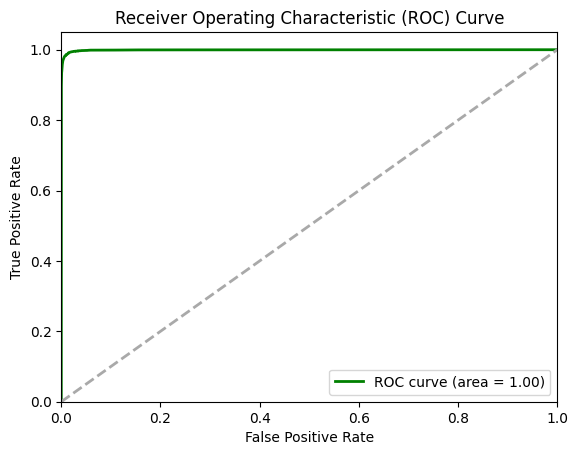

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score


fpr, tpr, _ = roc_curve(y_test, Rf.predict_proba(X_test)[:, 1])
roc_auc = roc_auc_score(y_test, Rf.predict_proba(X_test)[:, 1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkgrey', lw=2, linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


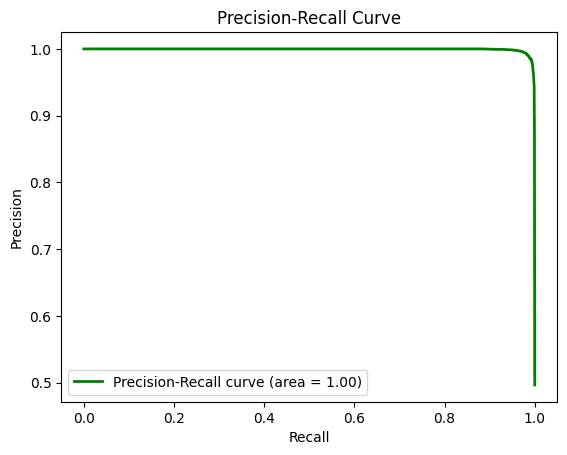

In [24]:
from sklearn.metrics import precision_recall_curve, average_precision_score


precision, recall, _ = precision_recall_curve(y_test, Rf.predict_proba(X_test)[:, 1])
average_precision = average_precision_score(y_test, Rf.predict_proba(X_test)[:, 1])

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall curve (area = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
